# <img style="float: left; padding: 0px 10px 0px 0px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg/1920px-Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg.png"  width="80" /> MCD3100 - Ciencia de Datos Geoespaciales
**Pontificia Universidad Católica de Chile**<br>
**Magister en Ciencia de Datos**<br>

# Tutorial 3: Datos vectoriales II.


Este tutorial tiene como objetivos:
- Construir geometrías envolventes como la envoltura convexa y el rectángulo envolvente.
- Calcular distancias entre geometrías y entre geoseries.
- Generar mapas interactivos.

### Contexto: 

En diciembre de 2022, Viña del Mar sufrió un [grave incendio urbano-forestal](https://www.bbc.com/mundo/noticias-america-latina-64073289) que comenzó en una zona de vegetación cercana a Rodelillo y, debido al viento intenso y a las condiciones de sequedad, avanzó rápidamente hacia sectores habitados. El fuego destruyó numerosas viviendas, dejó cientos de damnificados y provocó la muerte de dos personas, generando una emergencia en plena víspera de Navidad. Las autoridades declararon alerta roja y estado de catástrofe, movilizando a brigadas, bomberos y equipos de apoyo para contener el siniestro y asistir a las familias afectadas. El incendio evidenció la alta vulnerabilidad de algunos asentamientos y la necesidad de fortalecer la planificación territorial y la prevención de incendios forestales en la región.


In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import contextily as ctx

## 2. Datos.

A  nuestros datos anteriores
- `vm_comuna.gpkg`
- `vm_manz.gpkg`

Agregamos dos nuevas capas:

-`Edificaciones.shp`: edificaciones catastradas luego del gran incendio de diciembre 2022. Por cada vivienda catastrada, se incluye la huella de edificación, y una clasificación del tipo de daño ocasionado por el incendio: *Ninguno*, *Parcial*, o *Total*.

-`grifos_nacionales_2022.shp`: listado de grifos existentes en Chile, de acuerdo a la información de la Superintendencia de Servicios Sanitarios.


## 3. Ejercicios.



### 3.1 Lectura e inspección de datos vectoriales.

In [3]:
vina=gpd.read_file('data_T2/vm_comuna.gpkg')
manz=gpd.read_file('data_T2/vm_manz.gpkg')


<Axes: >

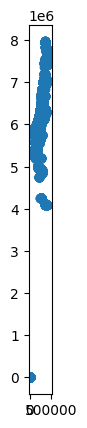

In [4]:
grifos=gpd.read_file('data_T3/data_T3/Grifos/grifos_nacionales_2022.shp').to_crs(32719)
grifos.plot()

### 3.2 Selección de viviendas dañadas

In [5]:
edif=gpd.read_file('data_T3/data_T3/Edificaciones.shp').to_crs(32719)
damaged=edif[edif['N_Daño']!='Ninguno']

In [6]:
edif.head()

,Id,N_Pisos,Orientacio,Dist_Veget,Tamaño,Dist_estru,Prep_vivie,Mant_viv,N_Daño,Elevación,...,N_Conj20m,H_Viv,Cord_X,Cord_Y,Codigo_Pol,Dist_Sup,Material,Ac_Supresi,Dist_Foco,geometry
0,0,8.0,NW,0.000000,416.620905,14.618534,Si,Si,Ninguno,98.769408,...,12.0,24.0,261698.364074,6.342136e+06,4006.0,130.769547,Sólido,Directo,94.833282,"POLYGON ((261696.949 6342153.144, 261697.232 6..."
1,0,8.0,NW,0.000000,177.487810,4.581179,Si,Si,Ninguno,112.203981,...,12.0,24.0,261728.482158,6.342111e+06,4007.0,150.980316,Sólido,Equipo,115.498544,"POLYGON ((261719.386 6342113.012, 261719.886 6..."
2,0,8.0,NW,1.413844,178.448386,4.581179,Si,Si,Ninguno,116.525468,...,12.0,24.0,261737.509320,6.342095e+06,4008.0,158.209747,Sólido,Equipo,123.252330,"POLYGON ((261730.392 6342098.534, 261730.879 6..."
3,0,8.0,NW,0.000000,179.175986,7.035498,Si,Si,Ninguno,116.349641,...,12.0,24.0,261751.563503,6.342116e+06,4009.0,178.044281,Sólido,Equipo,138.898349,"POLYGON ((261743.24 6342111.604, 261743.388 63..."
4,0,8.0,NW,0.981303,187.498583,7.258083,Si,Si,Ninguno,110.370876,...,12.0,24.0,261705.375710,6.342072e+06,4010.0,132.135742,Sólido,Equipo,95.493945,"POLYGON ((261700.653 6342080.531, 261701.207 6..."


<Axes: >

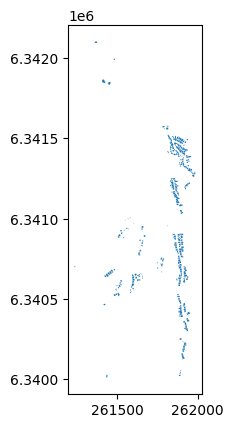

In [7]:
damaged.plot()

### 3.3 Envoltura, envoltura convexa y clip.

Para identificar el área afectada por el incendio, podemos usar la evoltura convexa o el rectángulo envolvente de las viviendas dañadas. Para ello es encesario unir todas las geometrías (con [union_all](https://geopandas.org/en/latest/docs/reference/api/geopandas.GeoSeries.union_all.html) o [unary_union](https://geopandas.org/en/v0.9.0/docs/reference/api/geopandas.GeoSeries.unary_union.html) ), y luego calcular la envolvente con [convex_hull](https://geopandas.org/en/v1.1.1/docs/reference/api/geopandas.GeoSeries.convex_hull.html) o [envelope](https://geopandas.org/en/latest/docs/reference/api/geopandas.GeoSeries.envelope.html). Es conveniente usar la geometría resultante para crear un nuevo `GeoDataFrame`.


In [19]:
cv=gpd.GeoDataFrame(geometry=[damaged.union_all().convex_hull],crs=edif.crs) #envoltura convexa
env=gpd.GeoDataFrame(geometry=[edif.union_all().envelope],crs=edif.crs) #rectángulo envolvente

<Axes: >

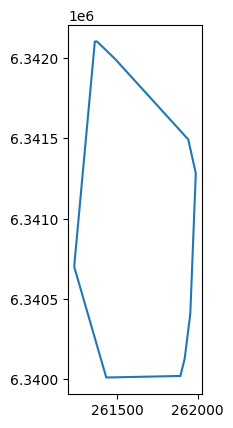

In [20]:
cv.boundary.plot()

<Axes: >

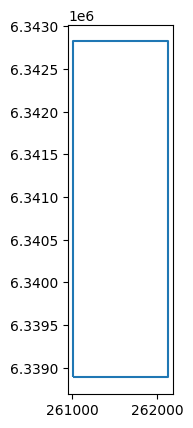

In [21]:
env.boundary.plot()

Para seleccionar sólo los grifos en el área de interés, recortamos el dataset usando [clip](https://geopandas.org/en/stable/docs/reference/api/geopandas.clip.html).

In [22]:
grifos=grifos.clip(env)

### 3.4 Gráfico.

C:\Users\Erick\AppData\Local\Temp\ipykernel_16856\460316562.py:13: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend();


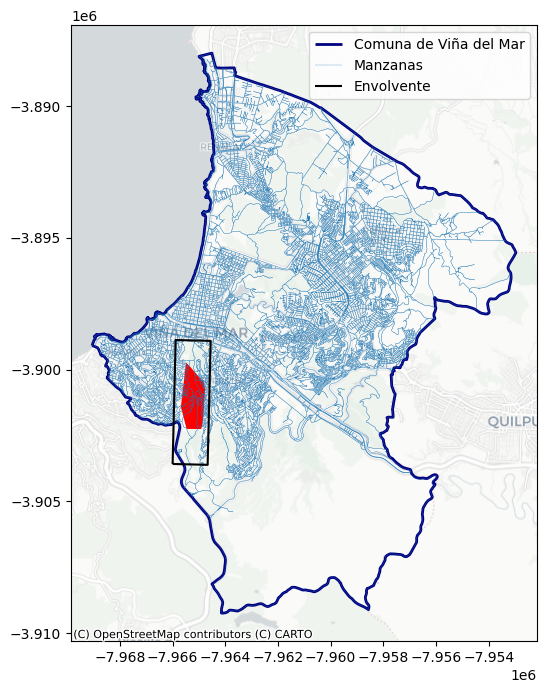

In [14]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

crs='3857'

vina.to_crs(crs).boundary.plot(ax=ax,color='navy',lw=2,label='Comuna de Viña del Mar')
manz.to_crs(crs).boundary.plot(ax=ax,lw=0.2,label='Manzanas')
cv.to_crs(crs).plot(ax=ax,color='r',label='Incendio')
env.to_crs(crs).boundary.plot(ax=ax,color='k',label='Envolvente')


ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.legend();
plt.show()

C:\Users\Erick\AppData\Local\Temp\ipykernel_16856\1065153385.py:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


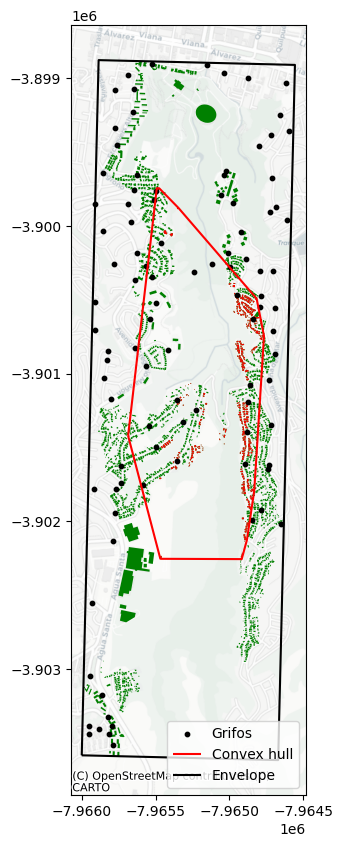

In [23]:
# ahora veamos mejor el area de interes

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

crs='3857'
edif.to_crs(crs).plot(ax=ax,color='g',label='Catastro')
damaged.to_crs(crs).plot(ax=ax,color='r',label='Dañadas')
grifos.to_crs(crs).plot(ax=ax,color='k',label='Grifos',markersize=10)

cv.to_crs(crs).boundary.plot(ax=ax,color='r',label='Convex hull')
env.to_crs(crs).boundary.plot(ax=ax,color='k',label='Envelope')


ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.legend()
plt.show()

### 3.5 Mapa interactivo con Folium

[Folium](https://python-visualization.github.io/folium/latest/) es una librería de Python que permite crear mapas interactivos de forma sencilla utilizando [Leaflet.js](https://leafletjs.com/) como motor de visualización. Su mayor ventaja es que combina la facilidad de Python con la capacidad de generar mapas web dinámicos que pueden visualizarse directamente en un Jupyter Notebook, guardarse como archivos HTML o integrarse en aplicaciones web.

En ciencia de datos geoespacial, `Folium` es útil para explorar datos espaciales de forma interactiva, permitiendo hacer zoom, mover el mapa y visualizar capas superpuestas.

In [24]:
cv.to_crs(4326).centroid

C:\Users\Erick\AppData\Local\Temp\ipykernel_16856\570692189.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cv.to_crs(4326).centroid


0    POINT (-71.55284 -33.04395)
dtype: geometry

In [25]:
import folium
m= folium.Map(location=[-33.04,-71.55], tiles="CartoDB Positron", zoom_start=14)

folium.GeoJson(grifos,marker=folium.Circle(radius=10, fill_color="gold", fill_opacity=1, color="black", weight=1)).add_to(m)
folium.GeoJson(cv,style_function=lambda x: {"color":"blue"}).add_to(m)
folium.GeoJson(env,style_function=lambda x: {"color":"gray"}).add_to(m)

folium.GeoJson(damaged,style_function=lambda x: {"fillColor": "red","color":"red","weight":1}).add_to(m)
m.save("vina.html")

m

### 3.6 ¿Cuál es la distribución de distancias entre cada vivienda quemada, y el grifo más cercano?


La función [sjoin_nrearest](https://geopandas.org/en/latest/docs/reference/api/geopandas.sjoin_nearest.html) permite unir capas en base a la menor distancie entre elementos de las geoseries. En este caso, justamente queremos agregar a cada vivienda dañada, la distancia al grifo más cercano.


In [28]:
# retorna un gdf con las casas dañadas junto con su grifo más cercano
joined_gdf = damaged.sjoin_nearest(grifos, distance_col="distance")
joined_gdf.head()

,Id,N_Pisos,Orientacio,Dist_Veget,Tamaño,Dist_estru,Prep_vivie,Mant_viv,N_Daño,Elevación,...,UBICACION,ZONA_RIESG,OTRA_ZONA_,MODELO,DIAMETRO_N,DIAMETRO_C,ANO_INSTAL,UTM_ESTE,UTM_NORTE,distance
45,0,1.0,W,0.000000,16.883714,6.815866,No,No,Total,171.080686,...,GR_ANCUD/OSORNO_VIÃA,SIN RIESGO,0,COLUMNA,150,100,2002,261828.75,6341509.17,59.317704
46,0,1.0,W,0.000000,30.990514,0.000000,Si,No,Parcial,171.947062,...,GR_ANCUD/OSORNO_VIÃA,SIN RIESGO,0,COLUMNA,150,100,2002,261828.75,6341509.17,70.974842
47,0,1.0,W,0.000000,70.532400,0.000000,Si,No,Parcial,169.136757,...,GR_ANCUD/OSORNO_VIÃA,SIN RIESGO,0,COLUMNA,150,100,2002,261828.75,6341509.17,71.101635
48,0,1.0,W,1.675817,111.765176,1.071337,No,No,Total,177.429767,...,GR_ANCUD/OSORNO_VIÃA,SIN RIESGO,0,COLUMNA,150,100,2002,261828.75,6341509.17,3.287156
49,0,1.0,W,16.912094,88.308028,1.071337,Si,Si,Total,178.501688,...,GR_ANCUD/OSORNO_VIÃA,SIN RIESGO,0,COLUMNA,150,100,2002,261828.75,6341509.17,1.968076


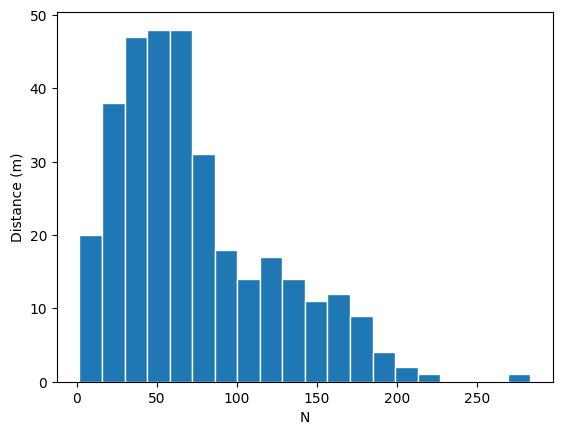

In [29]:
joined_gdf['distance'].hist(bins=20,edgecolor='white')
plt.ylabel('Distance (m)')
plt.xlabel('N')

plt.grid(False)

In [30]:
joined_gdf['distance'].mean() #metros

np.float64(74.53237637754223)